<a href="https://colab.research.google.com/github/andrkech/GENERATIVE-METHODS-IN-GENOMICS/blob/main/FASTQ_GENERATOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set up

In [1]:
!pip install -q biopython
import os
import random
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameters

In [2]:
READ_SIZE = 300
NUM_READS = 10000
SEED = 2

SCORES_DIR = "/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/GENERATED_PHREDS/20240815/synthetic_phred_scores.npy"
VARIANT_READS_DIR = "/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/VARIANT_READS/variant_reads_300_10000_0730.csv"

REAL_VARIANTS = True # Directly apply the given variants or generate similar
RANDOM_SCORES = False # Allocate random quality scores or specific ones

FASTQ_DIR = '/content/drive/MyDrive/BIOINFORMATICS/THESIS_KECHAGIAS/GENERATED_FASTQ_FILES'
os.makedirs(FASTQ_DIR, exist_ok=True)
FASTQ_DIR = os.path.join(FASTQ_DIR, f"synthetic_{datetime.now().strftime('%Y%m%d')}.fastq")

### Merge quality scores with variant reads.

In [19]:
def allocate_quality_scores(reads, quality_scores_tensor):
    # Convert tensor to list
    quality_scores_list = quality_scores_tensor.numpy().flatten().tolist()

    # Check if all the values are integers
    if not all(isinstance(score, int) for score in quality_scores_list):
        raise ValueError("All quality scores must be integers.")

    # Check for the length accordance
    if len(reads) * len(reads[0][0]) != len(quality_scores_list):
        raise ValueError("The total number of quality scores must match the total number of bases in all reads.")

    reads_with_quality_scores = []
    idx = 0
    for read, position, has_variant in reads:
        quality_scores = quality_scores_list[idx:idx + len(read)]
        reads_with_quality_scores.append((read, position, has_variant, quality_scores))
        idx += len(read)

    return reads_with_quality_scores

In [20]:
if RANDOM_SCORES:
    tf.random.set_seed(SEED)
    quality_scores_tensor = tf.random.uniform([NUM_READS, READ_SIZE], minval=0, maxval=41, dtype=tf.int32)
else:
    quality_scores_tensor = tf.convert_to_tensor(np.load(SCORES_DIR), dtype=tf.int32)

print(quality_scores_tensor[0])

tf.Tensor(
[33 33 32 33 33 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 36 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 32 37 36 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 38
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 36 37 37 37 36 37
 37 37 36 37 34 37 35 36 34 34 37 37 37 37 35 33 37 36 35 37 37 37 37 37
 37 36 37 36 37 33 36 36 37 36 36 36 36 36 37 36 37 37 37 37 35 37 36 36
 35 37 37 36 38 36 37 36 37 36 35 34], shape=(300,), dtype=int32)


In [21]:
variant_reads = pd.read_csv(VARIANT_READS_DIR)
variant_reads = variant_reads.values.tolist()
#print(variant_reads[0])

reads_plus_qs = allocate_quality_scores(variant_reads, quality_scores_tensor)

### Generate the FASTQ file.


In [22]:
def generate_fastq_file(reads_with_quality_scores, output_fastq_path):
    seq_records = []

    for read, position, has_variant, quality_scores in reads_with_quality_scores:
        seq_record = SeqRecord(
            Seq(read),
            id=f"instrument:run{1}:flowcell{1}:lane{1}:tile{1001}:pos{position}:variant{int(has_variant)}:0 1:N:0:sample{1}",
            description="",
            letter_annotations={"phred_quality": quality_scores}
        )
        seq_records.append(seq_record)

    # Write to FASTQ file
    with open(output_fastq_path, "w") as output_handle:
        SeqIO.write(seq_records, output_handle, "fastq")

In [23]:
generate_fastq_file(reads_plus_qs, FASTQ_DIR)

### Visualize FASTQ insights.

In [3]:
def plot_per_base_quality(fastq_file, num_reads_to_sample=NUM_READS):
    #Sample reads from the Fastq file
    records = random.sample(list(SeqIO.parse(fastq_file, "fastq")), num_reads_to_sample)

    max_read_length = max(len(record) for record in records)

    # Initialize quality score matrix (all positions, all reads)
    quality_scores = np.zeros((max_read_length, len(records)))

    #Extract quality scores
    for i, record in enumerate(records):
        quality_scores[:, i] = record.letter_annotations["phred_quality"]

    # Calculate median and IQR
    median_quality = np.median(quality_scores, axis=1)
    Q1 = np.percentile(quality_scores, 25, axis=1)
    Q3 = np.percentile(quality_scores, 75, axis=1)
    IQR = Q3 - Q1

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot the median
    plt.plot(range(1, max_read_length + 1), median_quality, color='green', marker='o', linestyle='-', label='Median')

    # Plot the IQR box plot with modified whisker positions to make space for error bars.
    #The whisker positions of the box plots are changed so that they are closer to the median line
    #and don't obscure the error bars.
    box_width = 0.4
    box_positions = range(1, max_read_length + 1)
    plt.boxplot(
        [quality_scores[i] for i in range(max_read_length)],
        positions=box_positions,
        widths=box_width,
        patch_artist=True,
        showmeans=False,
        showfliers=False,
        boxprops=dict(facecolor='lightgreen', color='green', alpha=0.7),
        medianprops=dict(color='green'),
        whiskerprops=dict(color='green'),
        capprops=dict(color='green'),
    )

    # Add labels, title, and ticks
    plt.xlabel('Position in Read (bp)')
    plt.ylabel('Phred Quality Score')
    plt.title('Per Base Sequence Quality')

    #X-ticks:
    x_ticks = range(1, max_read_length + 1, 5) # Sample every 5th position
    x_tick_labels = [str(i) if i % 10 == 0 or i == 1 else "" for i in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add horizontal gridlines
    plt.grid(axis='y')

    #Show plot
    plt.legend()
    plt.show()

def analyze_fastq(file_path, num_reads_to_sample=10000):
    # Initialize data structures
    quality_scores = []
    gc_content = []
    read_lengths = []

    # Sample reads
    reads = random.sample(list(SeqIO.parse(file_path, "fastq")), num_reads_to_sample)

    # Extract data for plotting
    for record in reads:
        quality_scores.extend(record.letter_annotations["phred_quality"])
        gc_content.append((record.seq.count("G") + record.seq.count("C")) / len(record.seq) * 100)
        read_lengths.append(len(record.seq))

    # Per Base Sequence Quality
    quality_counts = Counter(quality_scores)
    plt.bar(quality_counts.keys(), quality_counts.values())
    plt.xlabel("Phred Quality Score")
    plt.ylabel("Count")
    plt.title("Per Base Sequence Quality")
    plt.show()

    # Per Sequence GC Content
    plt.hist(gc_content, bins=20)
    plt.xlabel("GC Content (%)")
    plt.ylabel("Number of Reads")
    plt.title("Per Sequence GC Content")
    plt.show()

    # Sequence Length Distribution
    length_counts = Counter(read_lengths)
    plt.bar(length_counts.keys(), length_counts.values())
    plt.xlabel("Read Length")
    plt.ylabel("Count")
    plt.title("Sequence Length Distribution")
    plt.show()

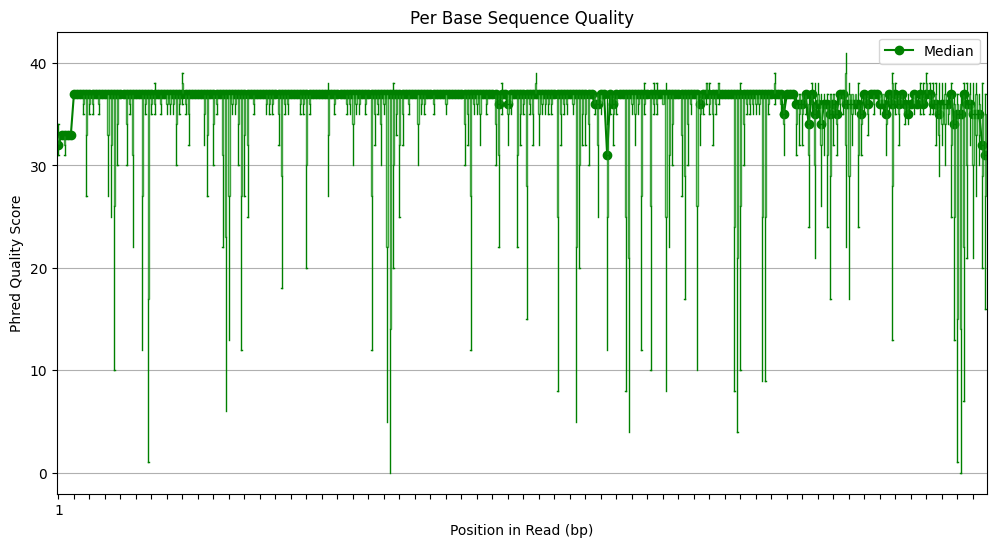

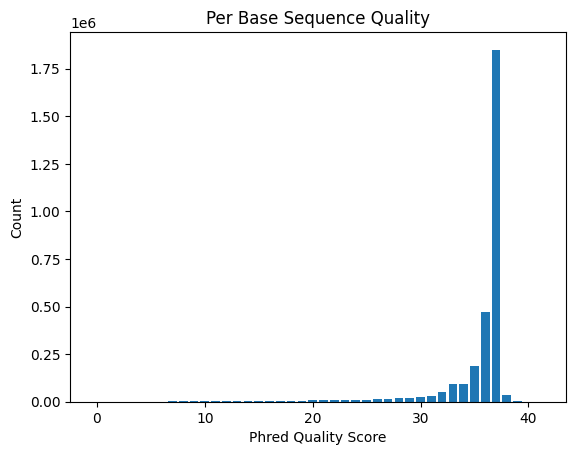

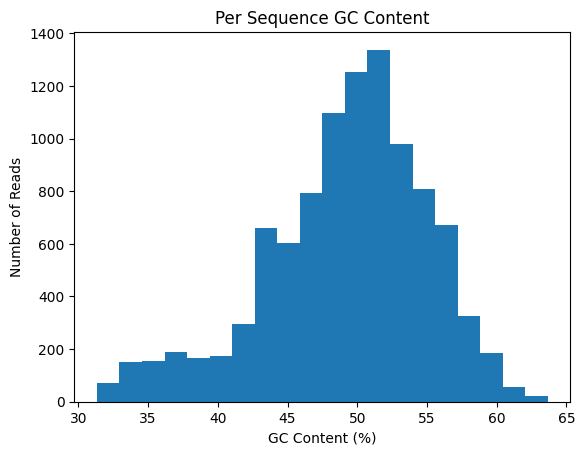

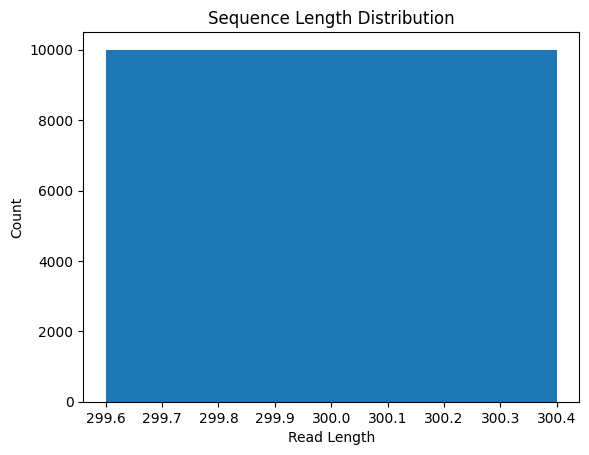

In [8]:
plot_per_base_quality(FASTQ_DIR)
analyze_fastq(FASTQ_DIR)